<a href="https://colab.research.google.com/github/as791/stAdv-PyTorch/blob/main/StAdv_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms,datasets
from scipy import optimize
import random

from tqdm.notebook import tqdm

##Train Model

In [2]:
class NetA(nn.Module):
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=5),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(0.25),
        nn.Linear(64*20*20, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10),
      )

    def forward(self, x):
      return self.model(x)


class NetB(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=8),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Conv2d(64, 128, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=5),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(128*12*12, 10)
    )

  def forward(self, x):
    return self.model(x)


class NetC(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 64, 3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.25),
      nn.Linear(64*24*24, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    return self.model(x)

In [3]:
def fit(model,device,train_loader,val_loader,optimizer,criterion,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  train_acc,val_acc=[],[]

  for epoch in tqdm(range(epochs)):
    loss_per_epoch,val_loss_per_epoch=0,0
    acc_per_epoch,val_acc_per_epoch,total,val_total=0,0,0,0
    for phase in ('train','val'):
      for i,data in tqdm(enumerate(data_loader[phase]), total= (55000 if phase == "train" else 5000)):
        inputs,labels  = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        #preding classes of one batch
        preds = torch.max(outputs,1)[1]
        #calculating loss on the output of one batch
        loss = criterion(outputs,labels)
        if phase == 'train':
          acc_per_epoch+=(labels==preds).sum().item()
          total+= labels.size(0)
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_acc_per_epoch+=(labels==preds).sum().item()
          val_total+=labels.size(0)
          val_loss_per_epoch+=loss.item()
    print("Epoch: {} Loss: {:0.6f} Acc: {:0.6f} Val_Loss: {:0.6f} Val_Acc: {:0.6f}".format(epoch+1,loss_per_epoch/len(train_loader),acc_per_epoch/total,val_loss_per_epoch/len(val_loader),val_acc_per_epoch/val_total))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
    train_acc.append(acc_per_epoch/total)
    val_acc.append(val_acc_per_epoch/val_total)
  return train_loss,val_loss,train_acc,val_acc

In [24]:
models = [NetA()]

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [55000, 5000])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
criterion = nn.CrossEntropyLoss()
# device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device = torch.device("cuda")
print(device)
for model in models:
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-6)
  train_loss,val_loss,train_acc,val_acc=fit(model,device,train_loader,val_loader,optimizer,criterion,20)
  torch.save(model.state_dict(),f'./{type(model).__name__}.pt')


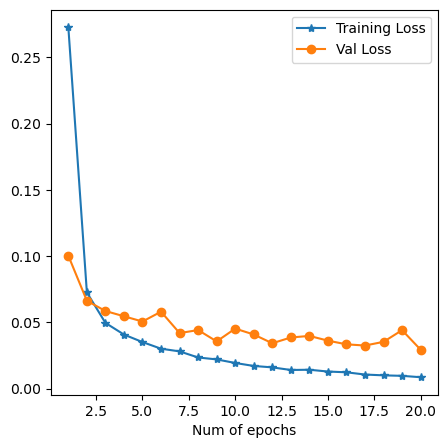

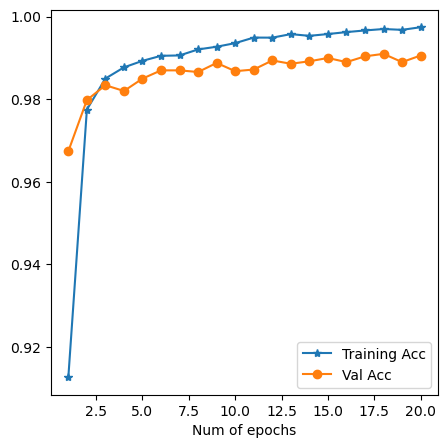

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), train_loss, "*-",label="Training Loss")
plt.plot(np.arange(1,21), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
# plt.savefig('loss_event.png')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), train_acc, "*-",label="Training Acc")
plt.plot(np.arange(1,21), val_acc,"o-",label="Val Acc")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
# plt.savefig('accuracy_event.png')

##stAdv Attack

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
#https://github.com/rakutentech/stAdv - refered code
def flow_st(images,flows):
  images_shape = images.size()
  flows_shape = flows.size()
  batch_size = images_shape[0]
  H = images_shape[2]
  W = images_shape[3]
  basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
  sampling_grid = basegrid.unsqueeze(0).type(torch.float32).to(device) + flows.to(device)
  sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
  sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)

  x0 = torch.floor(sampling_grid_x).type(torch.int64)
  x1 = x0 + 1
  y0 = torch.floor(sampling_grid_y).type(torch.int64)
  y1 = y0 + 1

  x0 = torch.clamp(x0, 0, W - 2)
  x1 = torch.clamp(x1, 0, W - 1)
  y0 = torch.clamp(y0, 0, H - 2)
  y1 = torch.clamp(y1, 0, H - 1)

  Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
  Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
  Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
  Id = images[:,:,y1[0,:,:], x1[0,:,:]]

  x0 = x0.type(torch.float32)
  x1 = x1.type(torch.float32)
  y0 = y0.type(torch.float32)
  y1 = y1.type(torch.float32)

  wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
  wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
  wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
  wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)

  perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id

  return perturbed_image.type(torch.float32).to(device)

In [12]:
def default_flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2
  loss=0
  for shifted_flow in shifted_flows:

    #This should be the loss but works worse and is slower
    up_uq = torch.square(flows[:, 1] - shifted_flow[:, 1])
    vp_vq = torch.square(flows[:, 0] - shifted_flow[:, 0])

    loss += torch.sum(torch.sqrt(up_uq + vp_vq + epsilon)).to(device)

  return loss.type(torch.float32)

def adv_loss(logits,targets,confidence=0.0):
  confidence=torch.tensor(confidence).to(device)
  real = torch.sum(logits*targets,-1)
  other = torch.max((1-targets)*logits-(targets*10000),-1)[0]
  return torch.max(other-real,confidence)[0].type(torch.float32)

In [13]:
def weird_flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2
  loss=0
  for shifted_flow in shifted_flows:
    #Weird Loss:
    up_uq = torch.square(torch.norm(flows[:, 1] - shifted_flow[:, 1], 2))
    vp_vq = torch.square(torch.norm(flows[:, 0] - shifted_flow[:, 0], 2))

    #This should be the loss but works worse and is slower
    # up_uq = torch.square(flows[:, 1] - shifted_flow[:, 1])
    # vp_vq = torch.square(flows[:, 0] - shifted_flow[:, 0])

    loss += torch.sum(torch.sqrt(up_uq + vp_vq + epsilon)).to(device)

  return loss.type(torch.float32)

In [14]:
losses = [default_flow_loss, weird_flow_loss]

In [15]:
def func(flows,input,target,model,flow_loss,const=0.05):
  input = torch.from_numpy(input).to(device)
  target = torch.from_numpy(target).to(device)
  flows = torch.from_numpy(flows).view((1,2,)+input.size()[2:]).to(device)
  flows.requires_grad=True
  pert_out = flow_st(input,flows)
  output = model(pert_out)
  L_flow = flow_loss(flows)
  L_adv = adv_loss(output,target)
  L_final = L_adv+const*L_flow
  model.zero_grad()
  L_final.backward()
  gradient = flows.grad.data.view(-1).detach().cpu().numpy()
  # print(f'{gradient=}')
  return L_final.item(), gradient

In [16]:
def attack(input,target,model,flow_loss):
  init_flows = np.zeros((1,2,)+input.size()[2:]).reshape(-1)

  results = optimize.fmin_l_bfgs_b(func, init_flows, args=(input.cpu().numpy(), target.cpu().numpy(), model, flow_loss))

  if 'CONVERGENCE' in results[2]['task']:
    flows = torch.from_numpy(results[0]).view((1,2,) + input.size()[2:])
    pert_out = flow_st(input,flows)

  else:
    return None

  return pert_out

In [25]:
models[0].load_state_dict(torch.load("model.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [152]:
class Attacker:
    def __init__(self, model, testset, loss_func) -> None:
        self.model = model
        # self.testset = testset
        self.loss_func = loss_func
        targets = testset.targets
        self.targeted_samples = dict()
        self.labels = torch.unique(targets, sorted=True).tolist()
        for label in self.labels:
            label_indices = testset.targets == label
            self.targeted_samples[label] = testset.data[label_indices]
    
    def get_label_sample(self, label):
        num_samples = len(self.targeted_samples[label])
        source_img = (
            self.targeted_samples[label][random.randrange(0, num_samples)]
            .unsqueeze(0)
            .unsqueeze(0)
        )
        return source_img
    
    def attack_from_to(self, source_label, target_label):
        return self.attack_img_to(self.get_label_sample(source_label), target_label)
        

    def attack_img_to(self, source_img, target_label):
        # plt.imshow(source_img[0,0,:,:], cmap='gray')
        # target_label_np = np.array([target_label])
        target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[target_label],0)).to(device)
        # loss = loss_function if loss_function is not None else self.loss_func
        init_flows = np.zeros(
            (
                1,
                2,
            )
            + source_img.size()[2:]
        ).reshape(-1)

        results = optimize.fmin_l_bfgs_b(
            func,
            init_flows,
            args=(
                source_img.cpu().numpy(),
                target.cpu().numpy(),
                # target_label,
                # target_label_np,
                model,
                self.loss_func,
            ),
        )
        # print(results[2])

        flows = torch.from_numpy(results[0]).view(
            (
                1,
                2,
            )
            + source_img.size()[2:]
        )
        # print((flows == 0).all())
        pert_out = flow_st(source_img, flows)
        # plt.imshow(pert_out[0, 0, :, :], cmap="gray")
        return pert_out

    def attack_all(self):
        sample_shape = self.targeted_samples[self.labels[0]][0].size()
        attack_grid = torch.zeros((len(self.labels), len(self.labels)) + sample_shape)
        for i, source_label in tqdm(enumerate(self.labels), total=len(self.labels)):
            num_samples = len(self.targeted_samples[source_label])
            source_img = (
                self.targeted_samples[source_label][random.randrange(0, num_samples)]
                .unsqueeze(0)
                .unsqueeze(0)
            )
            for j, target_label in tqdm(enumerate(self.labels), total=len(self.labels)):
                attack_grid[i, j] = self.attack_img_to(source_img, target_label)
        return attack_grid

    def print_attack_grid(self, attack_grid):
        plt.figure(figsize=(10, 10))
        cnt = 0
        for i, source_label in enumerate(self.labels):
            for j, target_label in enumerate(self.labels):
                cnt += 1
                plt.subplot(10, 10, cnt)
                plt.xticks([], [])
                plt.yticks([], [])
                orig, adv_, ex = i, j, attack_grid[i, j]
                # plt.title("{} -> {}".format(orig, adv_))
                plt.imshow(ex, cmap="gray")

        # for i in range(len(adv)):

        plt.tight_layout()

        plt.savefig(f"figures/figure_1.pdf")
        pass

In [146]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)

In [158]:
attacker = Attacker(models[0], testset, weird_flow_loss)

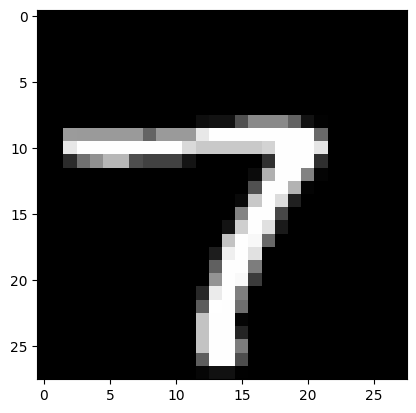

In [159]:
sample = attacker.get_label_sample(7)
plt.imshow(sample[0,0,:,:], cmap="gray")

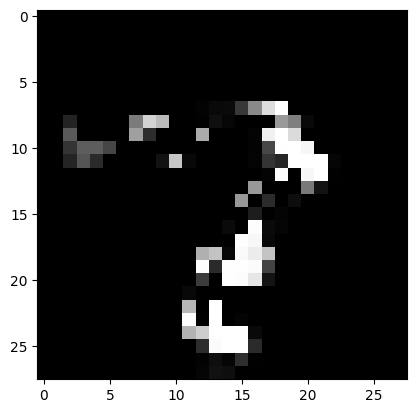

In [160]:
attack = attacker.attack_img_to(sample, 0)
plt.imshow(attack[0,0,:,:], cmap="gray")

In [161]:
attack_grid = attacker.attack_all()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

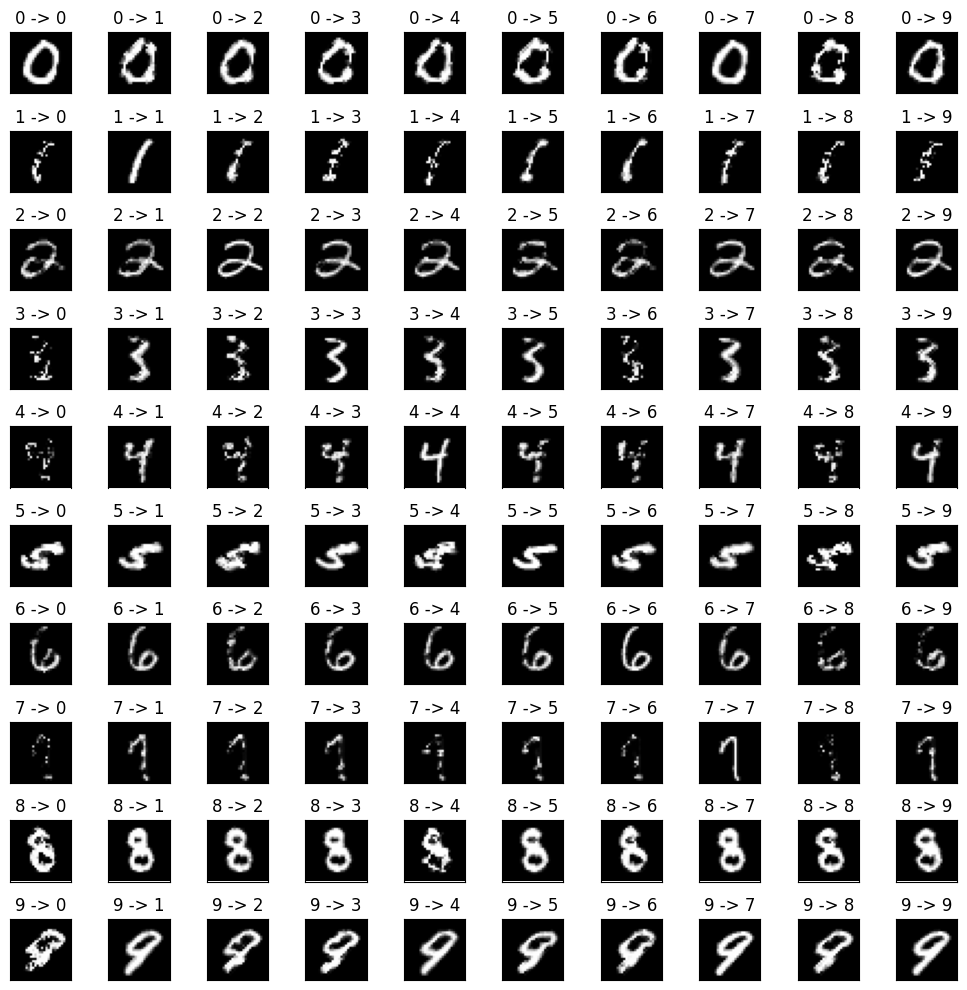

In [162]:
attacker.print_attack_grid(attack_grid)

In [22]:
testset_only_0_indices = testset.targets == 0
testset_only_0_data, targets = testset.data[testset_only_0_indices], testset.targets[testset_only_0_indices]
print(testset_only_0_data.shape)

torch.Size([980, 28, 28])
tensor(0) tensor(0)


In [29]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

# use_cuda=True
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

for model in models:
  for flow_loss in losses:
    # model = model.to(device)
    # model.load_state_dict(torch.load(f'./{type(model).__name__}.pt'))
    model.eval()

    adv=[]
    adv_label=[]
    correct_label=[]
    sample=100
    success=0
    print(f"Model: {type(model).__name__}")
    print(f"Loss: {flow_loss.__name__}")
    for i,data in tqdm(enumerate(test_loader), total=sample):
      if i<sample:
        input,label = data[0].to(device),data[1].to(device)
        break
        random_target = np.random.choice([num for num in range(10) if num != label.item()])
        target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0)).to(device)
        pert_out = attack(input,target,model, flow_loss)
        if pert_out!=None:
          output =  model(pert_out)
          adv.append(pert_out.squeeze().detach().cpu().numpy())
          correct_label.append(label.item())
          adv_label.append(torch.argmax(output).item())
          if label.item()!=torch.argmax(output).item():
            success+=1
      else:
        break
    print("Success Rate: {:.4f} ".format(success/sample))
    cnt = 0
    plt.figure(figsize=(10,10))

    for i in range(len(adv)):
      cnt += 1
      plt.subplot(10,10,cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      orig,adv_,ex = correct_label[i],adv_label[i],adv[i]
      plt.title("{} -> {}".format(orig, adv_))
      plt.imshow(ex, cmap="gray")

    plt.tight_layout()

    plt.savefig(f"figures/images_{flow_loss.__name__}_{type(model).__name__}.pdf")

Model: NetA
Loss: default_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
Success Rate: 0.0000 
Model: NetA
Loss: weird_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 1, 28, 28])
Success Rate: 0.0000 


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Success Rate: 0.7500 


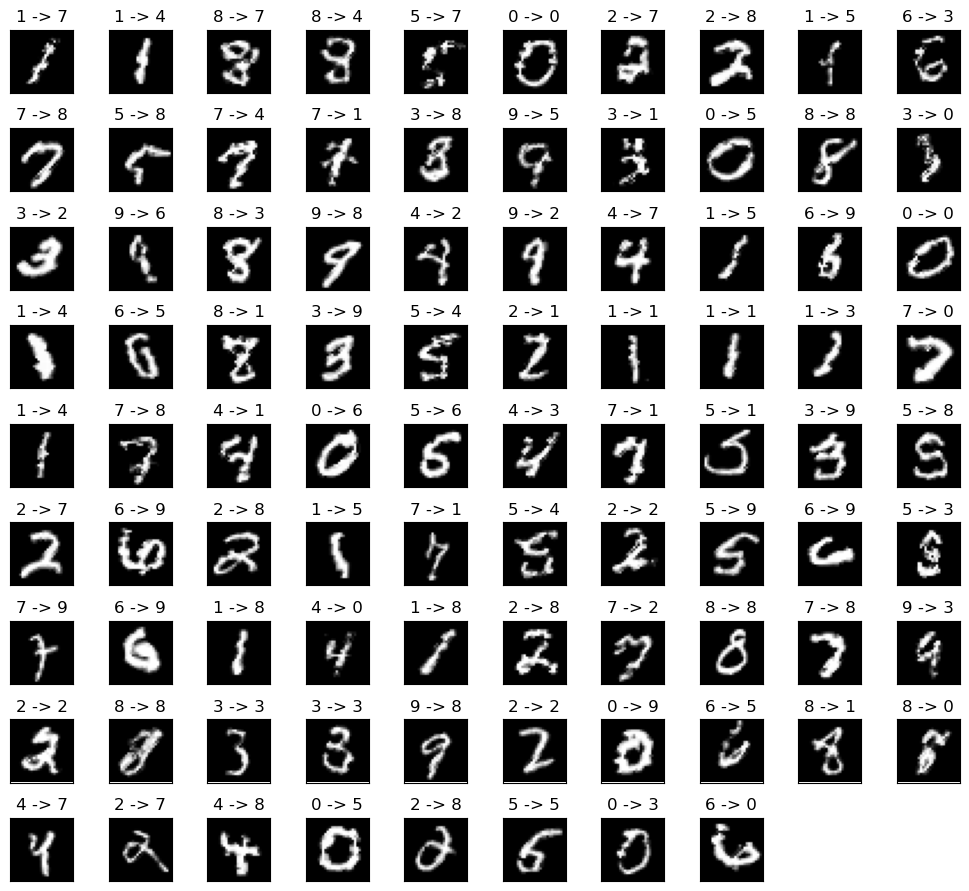